### Data Exploration
In this section we will explore the data that is being used for classification of icebergs from ships(or other objects in the sea). The dataset is extratcted from a competition on kaggle.com [competition](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge) [dataset](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data). 


**Some background**

* The dataset comprise of image data that was collected by Sentinal-1 constellation satellites those orbit ~600km above the surface of the earth. They orbit 14 times a day around earth and are responsibel for monitioring land and sea. 
* The satellites are mounted with a C-band radar, which works on same principle as that of radars on ships. A signal is transmitted out in the open and when the signal bounces off an object, the radar records the echo(bounced off signal intensity). This information is then translated into an image.
* The object appears bright when as it bounces off energy (the reflected energy is called as back scatter)
* More specifically, a Synthetic-aperture radar (SAR) is used for stellite imagery in this problem. It uses motion of radar antena over a spatial region(that needs to be captured) to generate high resolution images.
* SAR imagery is independent of flight altitude(for resolution) and weather.
* SAR can produce both 2D and 3D images. For 3D processing of an image, 2D image data is combined with incidence angle to give rise to 3rd dimension (elevation of object) 

In [8]:
# necessary imports
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# load data from json file
with open("train.json") as f:
    data = json.load(f)

In [3]:
data = pd.DataFrame(data)
display(data.head())
print("Number of examples in training dataset : ", len(data))
print("Values in band_1 : ", len(data["band_1"][0]))
print("Values in band_1 : ", len(data["band_1"][0]))
print("Total examples labelled as iceberg : ", data["is_iceberg"].sum())
print("Total examples labelled as not iceberg : ", len(data)-data["is_iceberg"].sum())

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


Number of examples in training dataset :  1604
Values in band_1 :  5625
Values in band_1 :  5625
Total examples labelled as iceberg :  753
Total examples labelled as not iceberg :  851


The structure of the data is depicted above. It is provided in the form of a JSON file having different fields that we are going to talk about now. One row of the data have imformation regarding one image of the dataset.
* **band_1** : This field conatins flattened image data of an image of dimension 75x75. This implies that we have a 1D vector of 5,625 values. The values do not explicitly indicate pixel values but some backscatter values that were recorded by the radar.
* **band_2** : Similar to band_1, it also contains flattened image data having 1x5625 values. The diffrence between band_1 and band_2 is of the different polarization of the radar at a perticular incidence angle. In band_1, both transmission and reciving of signal is done horizontally(HH) while in band_2, horizontal transmission and vertical recieving(HV). 
* **id** : id of the underlying image
* **inc_angle** : The incidence angle of the image that was taken. 
* **is_iceberg** : The target values of the data. 0 depicts that the image is of a ship(or something else) and 1 indicates that the image is of an iceberg.

### Visulaizations for more exploration
Now some exploratory visualizations to get a better idea of the images.
we will first collect some random images from the dataset (9 for each class)

In [4]:
iceberg_samples = data[data["is_iceberg"] == 1].sample(n=9, random_state=10)
noniceberg_samples = data[data["is_iceberg"] == 0].sample(n=9, random_state=10)

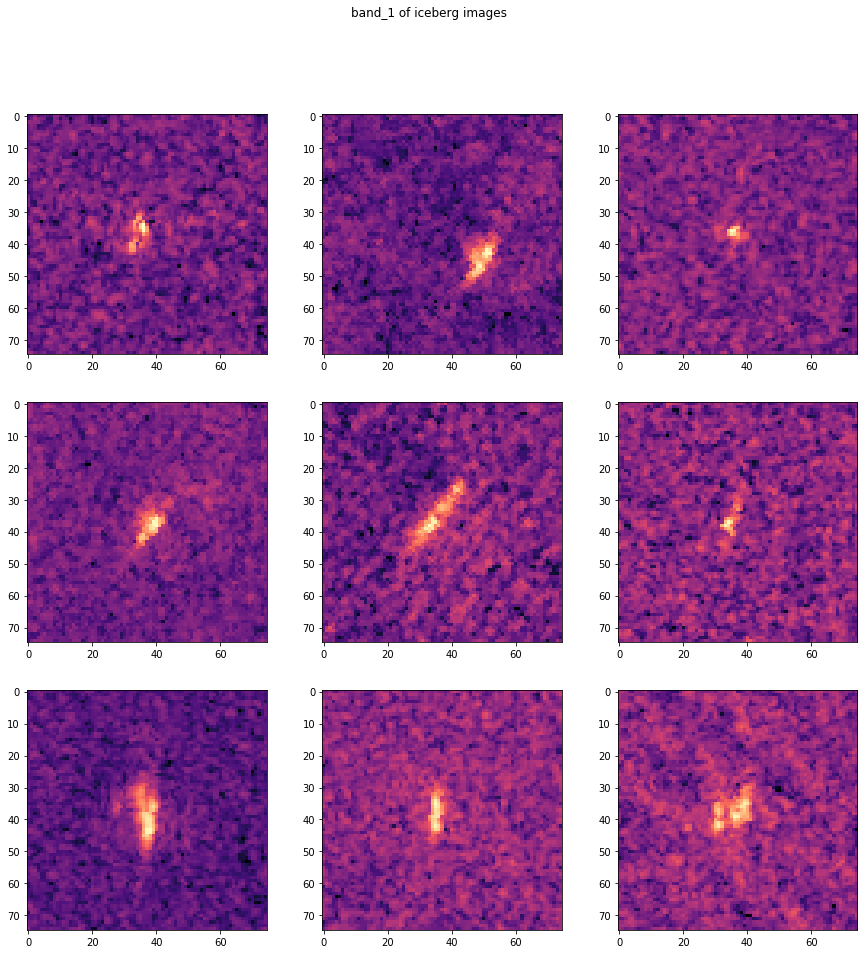

In [47]:
# plots of band_1 for iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("band_1 of iceberg images")
pos = 1
for i in iceberg_samples["band_1"]:
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(np.reshape(i, (75,75)), cmap="magma")
    pos+=1

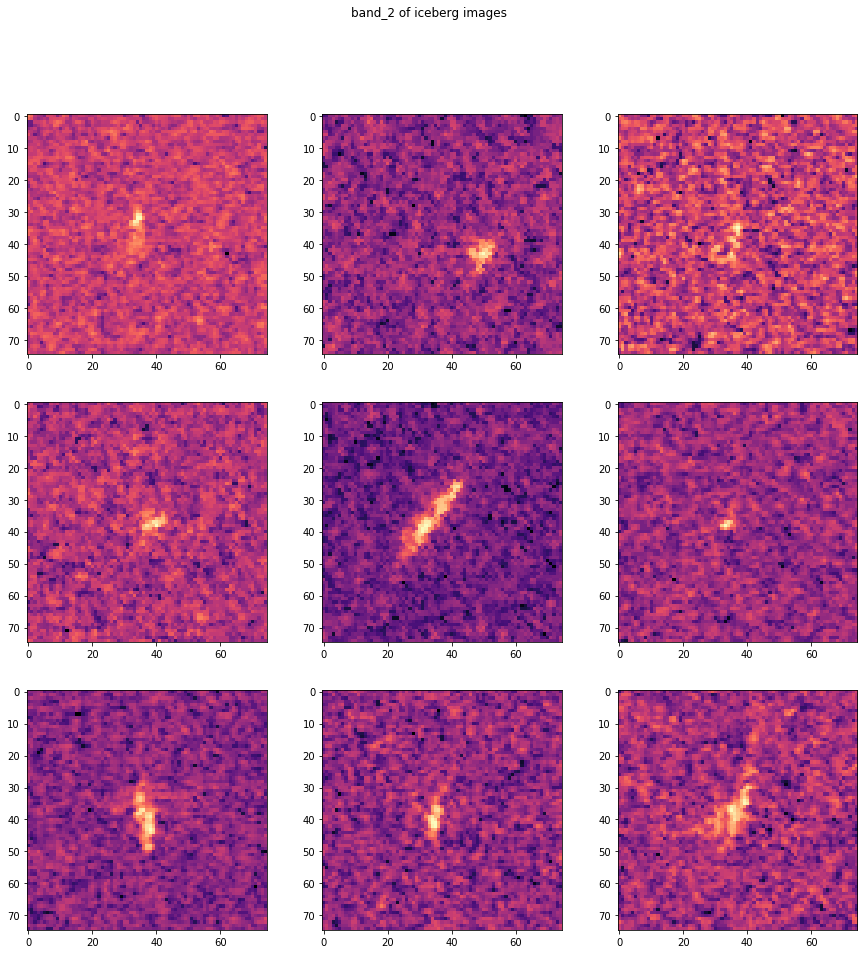

In [45]:
# plots of band_2 for iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("band_2 of iceberg images")
pos = 1
for i in iceberg_samples["band_2"]:
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(np.reshape(i, (75,75)), cmap="magma")
    pos+=1

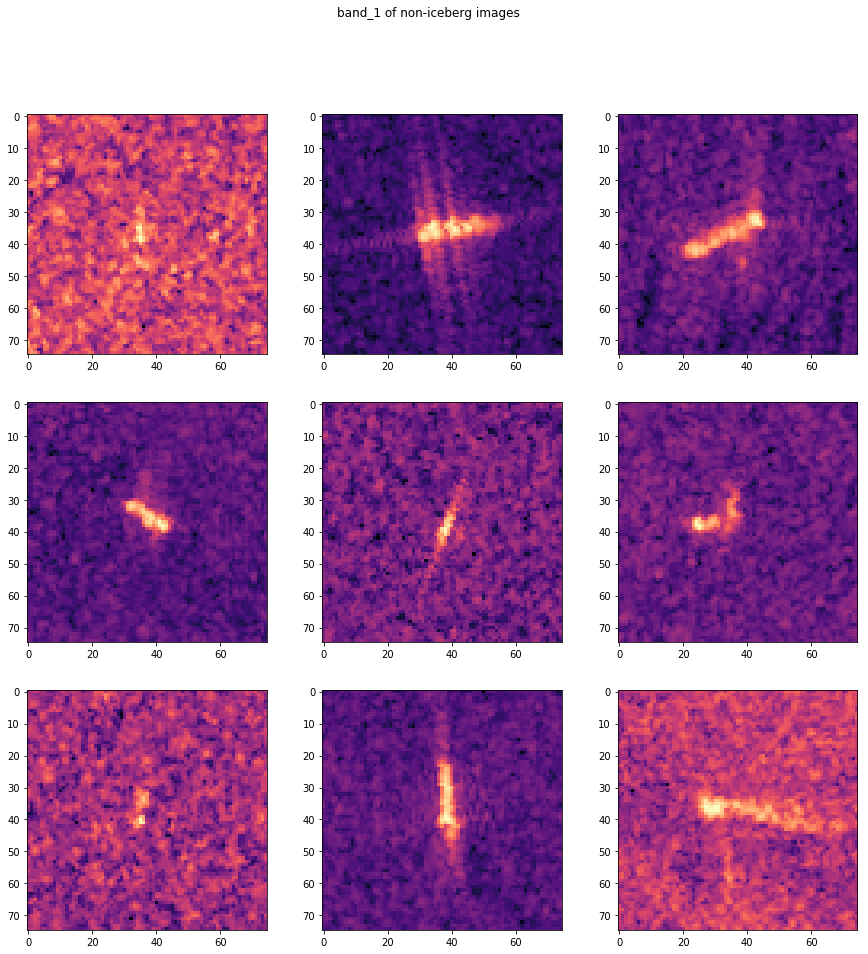

In [46]:
# plots of band_1 for non-iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("band_1 of non-iceberg images")
pos = 1
for i in noniceberg_samples["band_1"]:
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(np.reshape(i, (75,75)), cmap="magma")
    pos+=1

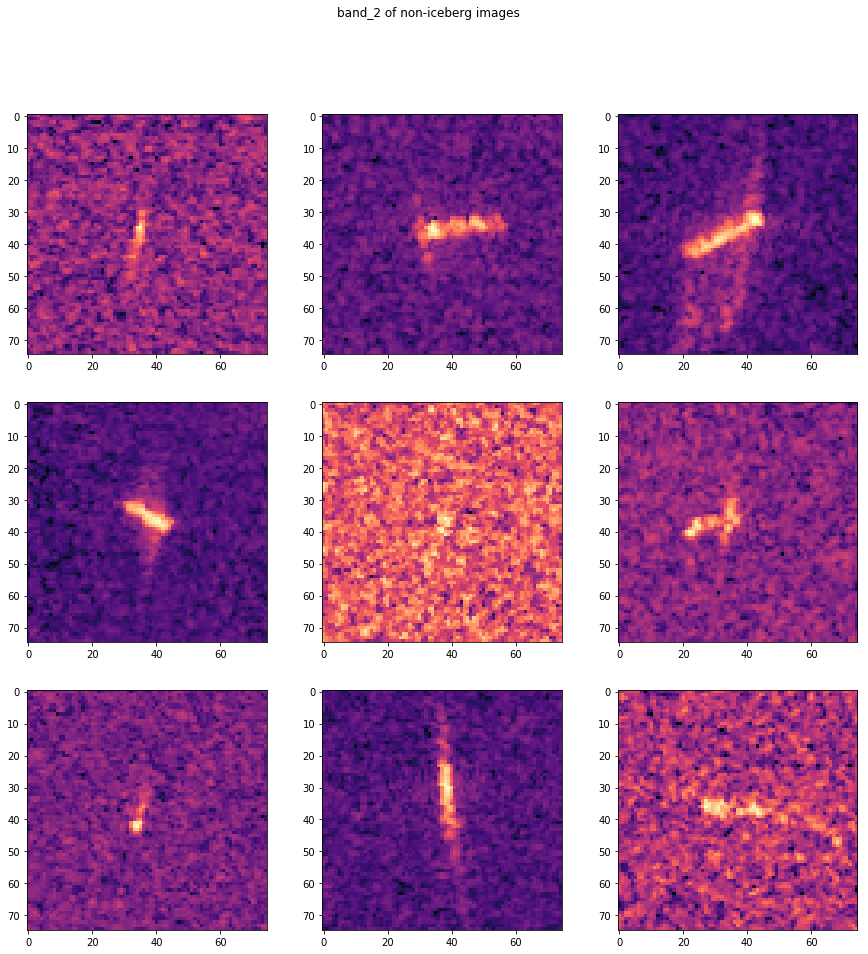

In [48]:
# plots of band_2 for non-iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("band_2 of non-iceberg images")
pos = 1
for i in noniceberg_samples["band_2"]:
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(np.reshape(i, (75,75)), cmap="magma")
    pos+=1

In the images above we can see that band_2 of both types of images is a noisy as compared to band_1. Now we will work on coming up with a third band by combining the two available bands in some way. This may help in noise reduction.

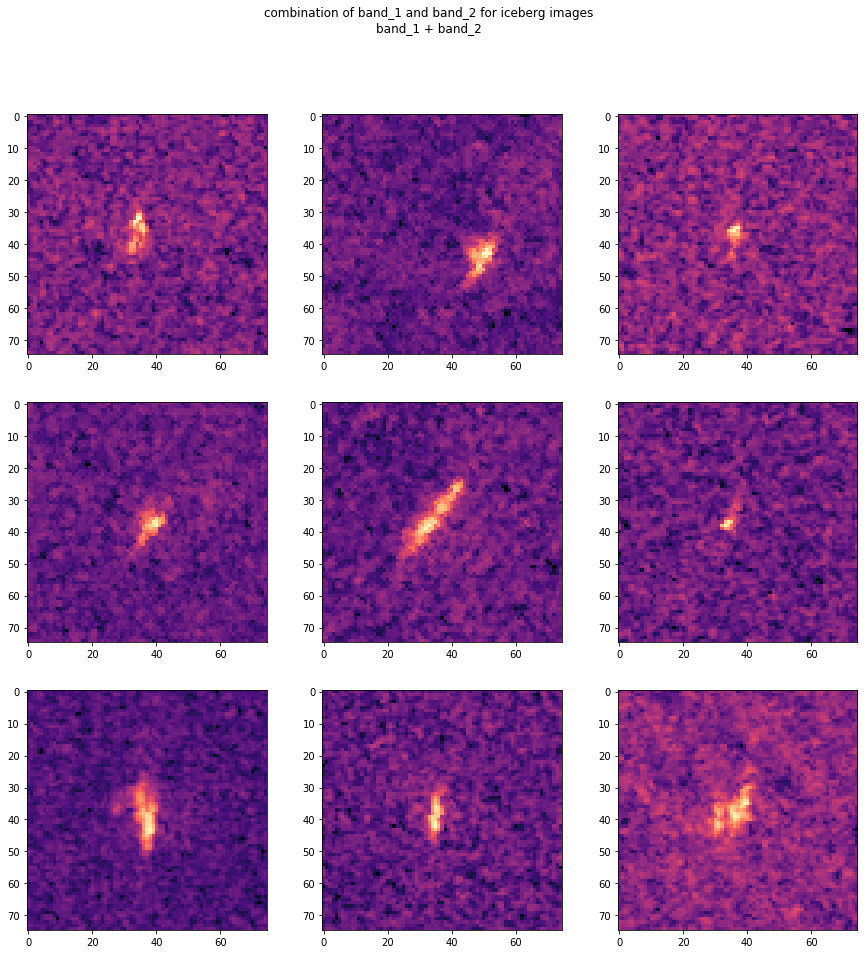

In [59]:
# plots of band_2 for non-iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("combination of band_1 and band_2 for iceberg images\nband_1 + band_2")
pos = 1
for i, j in zip(iceberg_samples["band_1"], iceberg_samples["band_2"]):
    band_1 = np.reshape(i, (75, 75))
    band_2 = np.reshape(j, (75, 75))
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(band_1+band_2, cmap="magma")
    pos+=1

On comparision we can see that the combined images are better tahn that of band_2 and we can use them as third channel in our model as an input.
We also tried the averaged version of the above combination below

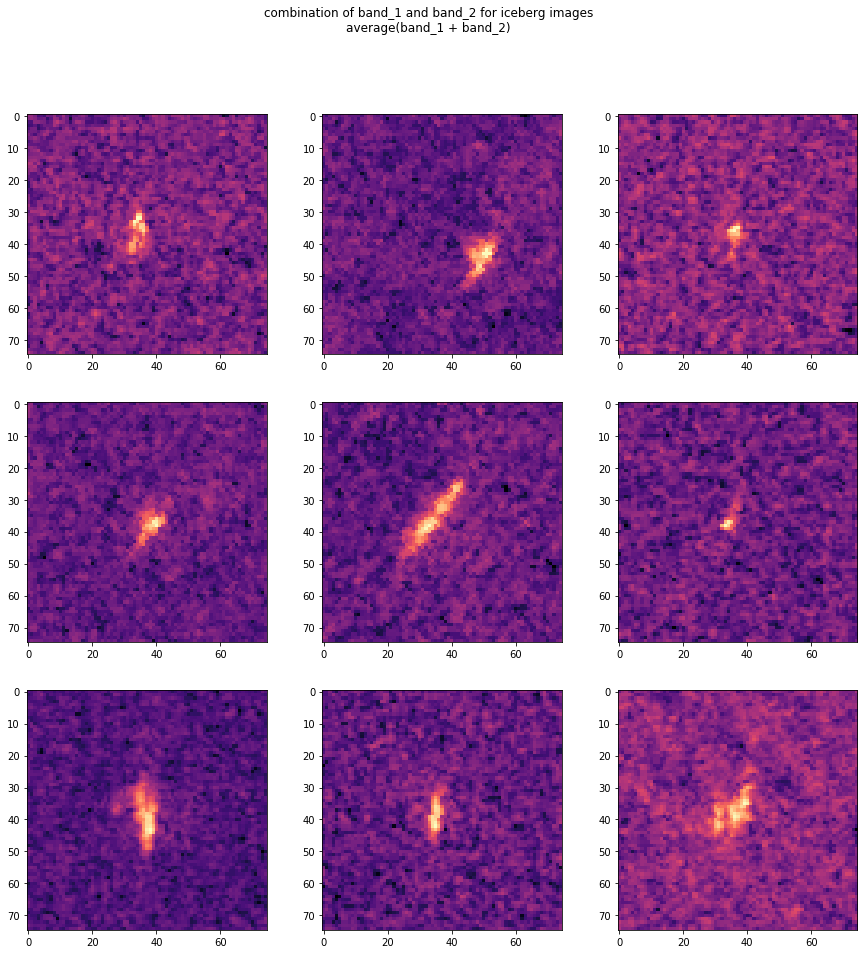

In [78]:
# plots of band_2 for non-iceberg samples
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("combination of band_1 and band_2 for iceberg images\naverage(band_1 + band_2)")
pos = 1
for i, j in zip(iceberg_samples["band_1"], iceberg_samples["band_2"]):
    band_1 = np.reshape(i, (75, 75))
    band_2 = np.reshape(j, (75, 75))
    plot = fig.add_subplot(3,3, pos)
    plot.imshow((band_1+band_2)/2, cmap="magma")
    pos+=1

Not so much diffrence as comapred to simple sum (band_1 + band_2). We will use simple sum of the two bands to generate a third channel(band) for input to our model. The underlyuing problen can then be treated as its RGB equivalents.  

Below depicted are the plots of normalized channel 3 (band_1 + band_2)

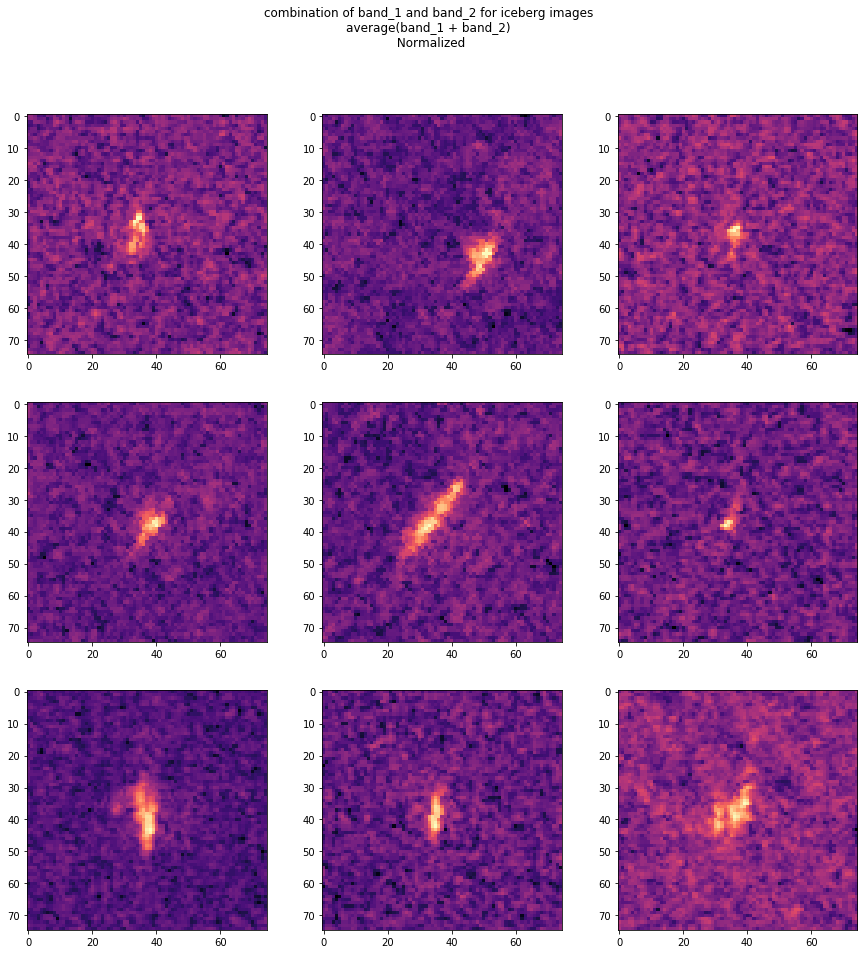

In [79]:
# plots of (band_2+band_3) for iceberg samples after normalization
fig = plt.figure(1, figsize=(15,15))
fig.suptitle("combination of band_1 and band_2 for iceberg images\naverage(band_1 + band_2)\n Normalized")
pos = 1
for i, j in zip(iceberg_samples["band_1"], iceberg_samples["band_2"]):
    band_1 = np.reshape(i, (75, 75))
    band_2 = np.reshape(j, (75, 75))
    new = band_1+band_2
    norm_new = (new - np.max(new))/(np.max(new) - np.min(new))+1
    plot = fig.add_subplot(3,3, pos)
    plot.imshow(norm_new, cmap="magma")
    pos+=1